In [20]:
from pyspark.sql import SparkSession
import os
from plotnine import *
from hurst import compute_Hc
from pandas.api.types import CategoricalDtype
import pandas as pd
import numpy as np
from more_itertools import peekable

import pyspark.sql.functions as F

In [21]:
traces_location = "<location to dir with trace directories>"
list_of_workloads = list(map(lambda x: os.path.join(traces_location, x), os.listdir(traces_location)))

In [22]:
intermediate_data_location = "/tmp/wta_hurst_data"

In [23]:
name_to_name_map = {
    "askalon_ee_": "Askalon Old 1",
    "askalon_ee2_": "Askalon Old 2",
    "Two": "Two Sigma",
    "LANL_Trinity": "LANL 1",
    "Google": "Google",
    "alibaba2018": "Alibaba"
}

In [24]:
spark = (SparkSession.builder
         .master("local[4]")
         .appName("Longitudinal Analysis")
         .config("spark.executor.memory", "8G")
         .config("spark.driver.memory", "2G")
         .getOrCreate())

In [25]:
def do_tasks_exist(workload_location):
    return "tasks" in os.listdir(workload_location)

def read_trace(workload_location):
    return spark.read.parquet(os.path.join(workload_location, "tasks", "schema-1.0"))

In [26]:
# We intend to calculate the hurst parameter for time scales:
# 100ms, 500ms, 1s, 5s, 10s, 50s, 100s, 500s, 1000s (16.6min.)
# We take 500 units for each time scale.
# So, the longest time series needs to be atleast 5.2 days long.
# This nicely matches with the time scale of our longitudinal analysis.
#
# For the short time scales (< 10s), we average over the hurst parameter 10 different time series selected from different points in the trace.

six_days_in_milliseconds = 1000*60*60*24*6

def is_trace_long_enough(tasks_df):
    # Exclude traces shorter than a week.
    max_timestamp = tasks_df.agg(F.max("ts_submit")).toPandas().loc[0, "max(ts_submit)"]
#     print(tasks_df.count())
#     print(max_timestamp)
    return max_timestamp >= six_days_in_milliseconds

In [27]:
time_scales = [100, 500, 1000, 1000*5, 1000*10, 1000*50, 1000*100, 1000*500, 1000*1000]
num_samples = [10, 10, 10, 10, 1, 1, 1, 1, 1]
size_of_sample = 500

In [28]:
for workload in list_of_workloads:
    if not str(workload).endswith("parquet"): continue
    if not do_tasks_exist(workload):
        continue
    
    trace = read_trace(workload)
    
    if not is_trace_long_enough(trace):
        continue
        
    loc_of_int_data_for_this_workload = os.path.join(intermediate_data_location, workload.split("/")[-1])
    os.makedirs(loc_of_int_data_for_this_workload, exist_ok=True)
        
    for index, time_scale in enumerate(time_scales):
        samples_to_collect = num_samples[index]
        
        tasks_per_time_period = trace.groupby(F.floor(F.col("ts_submit") / F.lit(time_scale)).alias("time_period")).count()
        
        (tasks_per_time_period.sort("time_period").filter(F.col("time_period") < F.lit(size_of_sample*samples_to_collect)).toPandas()
            .to_csv(os.path.join(loc_of_int_data_for_this_workload, "time_scale={}&num_samples={}&sample_size={}".format(time_scale, samples_to_collect, size_of_sample))))

In [29]:
def fill_in_missing_entries(dataset, totalEntries=100):
    filledDataset = None
    if dataset.shape[0] >= totalEntries:
        filledDataset = dataset.sort_values("time_period").reset_index(drop=True).loc[0:totalEntries, :]
    else:
        columnNames = dataset.columns.tolist()
        filledDataset = pd.DataFrame(index=np.arange(0, totalEntries),
                                     columns=columnNames,
                                     dtype=np.float64)
        startTime = dataset["time_period"].min()
        if np.isnan(startTime):
            startTime = 0
        datasetIter = peekable(dataset.sort_values("time_period").iterrows())
        for i in range(totalEntries):
            if datasetIter and int(datasetIter.peek()[1][0]) == (startTime + i):
                nextEntry = next(datasetIter)
                filledDataset.loc[i, :] = nextEntry[1].tolist()
            else:
                filledDataset.loc[i, :] = np.zeros(len(columnNames))
                filledDataset.loc[i, "time_period"] = float(startTime + i)
    
    return filledDataset

workload: Google_parquet
location: time_scale=100&num_samples=10&sample_size=500; dataset size: (1, 2)
workload: Google_parquet
location: time_scale=500&num_samples=10&sample_size=500; dataset size: (225, 2)
workload: Google_parquet
location: time_scale=1000&num_samples=10&sample_size=500; dataset size: (447, 2)
workload: Google_parquet
location: time_scale=5000&num_samples=10&sample_size=500; dataset size: (2110, 2)
workload: LANL_Trinity_parquet
location: time_scale=100&num_samples=10&sample_size=500; dataset size: (4, 2)
workload: LANL_Trinity_parquet
location: time_scale=500&num_samples=10&sample_size=500; dataset size: (7, 2)
workload: LANL_Trinity_parquet
location: time_scale=1000&num_samples=10&sample_size=500; dataset size: (7, 2)
workload: LANL_Trinity_parquet
location: time_scale=5000&num_samples=10&sample_size=500; dataset size: (27, 2)
workload: askalon_ee2_parquet
location: time_scale=100&num_samples=10&sample_size=500; dataset size: (58, 2)
workload: askalon_ee2_parquet
l

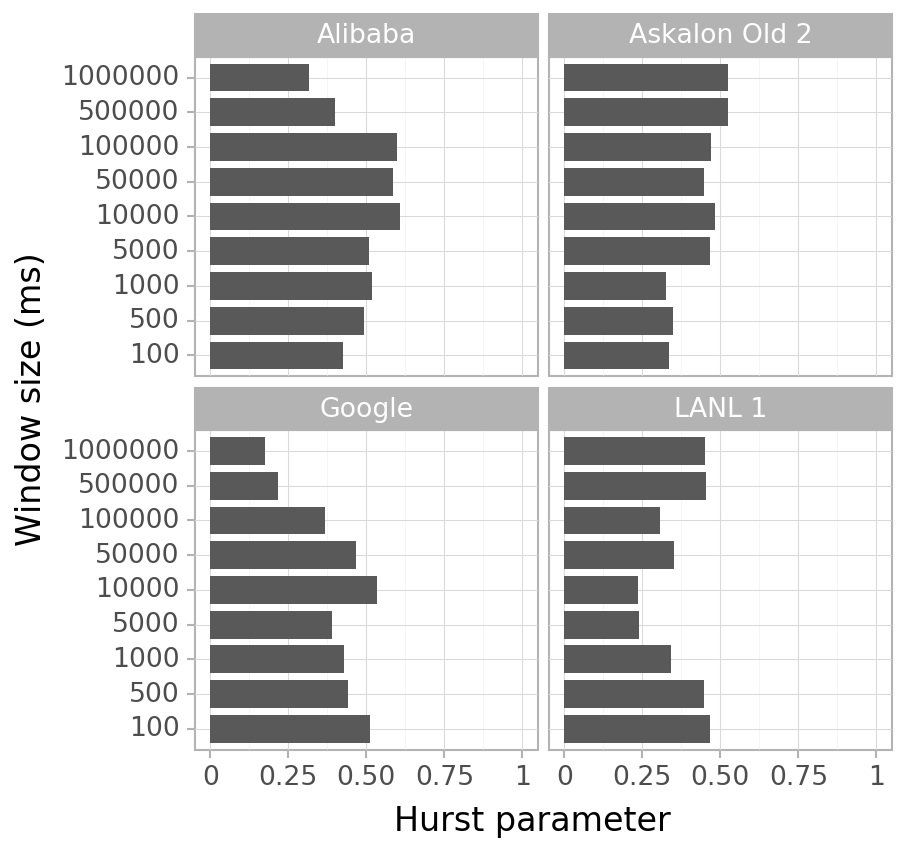

<ggplot: (-9223369104760794473)>

In [30]:
# We estimate the hurst parameter (long scale time dependence) of the extracted samples using rescaled range method.

list_of_hurst_parameters = []

window_size_cat = CategoricalDtype(categories=time_scales, ordered=True)

workloads_with_intermediate_data = os.listdir(intermediate_data_location)

for workload in workloads_with_intermediate_data:
    for window_size_index in range(len(time_scales)):
        dataset = pd.read_csv("{}/time_scale={}&num_samples={}&sample_size={}".format(os.path.join(intermediate_data_location, workload), 
                                                                                      time_scales[window_size_index], num_samples[window_size_index], size_of_sample),
                              header=0, index_col=0)
        
        workload_name = workload
    
        if workload_name.startswith("askalon-new_ee68_"):
            continue

        if workload_name.startswith("OLD"):
            continue
            
        if workload_name.startswith("workflowhub"):
            continue
        
        for start, full_name in name_to_name_map.items():
            if workload_name.startswith(start):
                workload_name = full_name
                break

        if num_samples[window_size_index] > 1:
            temp_list = []
            samples_collected = num_samples[window_size_index]
            print("workload: {}".format(workload))
            print("location: {}; dataset size: {}".format("time_scale={}&num_samples={}&sample_size={}".format(time_scales[window_size_index], num_samples[window_size_index], size_of_sample), dataset.shape))
            for i in range(0, samples_collected*size_of_sample, size_of_sample):
                dataset_to_clean = dataset[(dataset["time_period"] >= i) & (dataset["time_period"] < i+size_of_sample)]
                if dataset_to_clean.shape[0] == 0:
                    continue
                cleaned_dataset = fill_in_missing_entries(dataset_to_clean, totalEntries=size_of_sample)
                H, _, _ = compute_Hc(cleaned_dataset.loc[:, "count"].values)
                temp_list.append(H)

            list_of_hurst_parameters.append({
                "workload": workload_name,
                "window_size": time_scales[window_size_index],
                "hurst_parameter": sum(temp_list)/len(temp_list)
            })
        else:
            cleaned_dataset = fill_in_missing_entries(dataset, totalEntries=size_of_sample)
            H, _, _ = compute_Hc(cleaned_dataset.loc[:, "count"].values)
            list_of_hurst_parameters.append({
                "workload": workload_name,
                "window_size": time_scales[window_size_index],
                "hurst_parameter": H
            })
    
hpdf = pd.DataFrame(list_of_hurst_parameters)
hpdf["window_size"] = hpdf["window_size"].astype(window_size_cat)

plt = ggplot(hpdf) +\
    theme_light(base_size=16) +\
    theme(figure_size=(6, 6), dpi=150) +\
    facet_wrap(facets="workload") +\
    geom_bar(aes(x="window_size", y="hurst_parameter"), stat=stat_identity(), width=0.8) +\
    xlab("Window size (ms)") +\
    ylab("Hurst parameter") +\
    scale_y_continuous(limits=(0, 1)) +\
    coord_flip()

plt

/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 8 x 5 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/hurst_param.pdf
  warn('Filename: {}'.format(filename))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 8 x 5 in image.
  from_inches(height, units), units))
/var/scratch/stalluri/miniconda3/envs/WTA/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/hurst_param.pdf
  warn('Filename: {}'.format(filename))


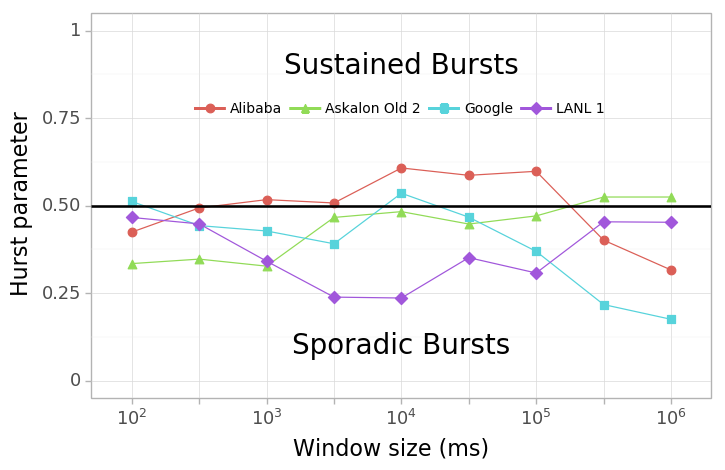

<ggplot: (-9223369104750969505)>

In [32]:
def formatXaxisLabels(xl):
    def format_e(n):
        a = '%E' % n
        return '$10^{' + a.split('E')[1][2:] + '}$'
    return list(map(lambda x: format_e(x), xl))

plt = ggplot(hpdf) +\
    theme_light(base_size=16) +\
    theme(legend_title=element_text(size=0, alpha=0),
           legend_box_spacing=0.01,
           legend_box_margin=0,
           legend_margin=0,
          legend_position=(0.51, 0.7),
          legend_direction="horizontal",
          legend_key=element_blank(),
          panel_grid_minor_x=element_line(size=1, color="grey"),
          legend_entry_spacing_y=0.1,
          legend_text=element_text(size=10),
          legend_background=element_rect(fill=(0,0,0,0))) +\
    geom_line(aes(x="window_size", y="hurst_parameter", color="workload", group="workload")) +\
    geom_point(aes(x="window_size", y="hurst_parameter", color="workload", shape="workload"), size=3) +\
    xlab("Window size (ms)") +\
    ylab("Hurst parameter") +\
    scale_y_continuous(limits=(0, 1)) +\
    scale_x_discrete(labels=["$10^2$", "", "$10^3$", "", "$10^4$", "", "$10^5$", "", "$10^6$"]) +\
    geom_hline(yintercept=0.5, size=1.05) +\
    annotate("text", x = 5, y = .9, label = "Sustained Bursts", size=20) +\
    annotate("text", x = 5, y = .1, label = "Sporadic Bursts", size=20)

ggsave(filename="./plots/hurst_param.pdf",
       plot=plt,
       device='pdf',
       dpi=600,
       height=5,
       width=8)
plt.save("./plots/hurst_param.pdf")
plt